In [1]:
# Analysis of global COVID-19 data

# Import relevant programs
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import image as image
from matplotlib import cbook as cbook
from matplotlib.colors import ListedColormap
# import matplotlib.gridspec as gridspec

In [2]:
#Load COVID Data

covid_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_data = covid_data.drop(columns=['Province/State', 'Lat', 'Long'])
covid_data.rename(columns = {'Country/Region': 'Country'}, inplace = True)
covid_data = covid_data.groupby('Country').agg('sum')

In [3]:
# Create a time series by transforming the covid.data 

covid_data = covid_data.T
datetime_index = pd.to_datetime(covid_data.index)
covid_data = covid_data.set_index(datetime_index)
covid_data.rename(columns = {'Korea, South': 'South Korea'}, inplace = True)

# covid_data.head()

In [4]:
stablized_countries = covid_data.loc[:, ['Iran', 'Japan', 'South Korea']]


In [5]:
#Phase 1 countries

phase1 = covid_data.loc[:, ['Austria', 'Belgium', 'Canada', 'France', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'US']]

# phase1.head(20)


In [20]:
#Cutoff for seeding cases

seed_cutoff = 100

In [21]:
#Truncate the COVID-19 cases based on the variable seed_cutoff, defined above

countries_100cuts = covid_data.where(covid_data > seed_cutoff, np.nan)

for col in countries_100cuts.columns:
    countries_100cuts[col] = sorted(countries_100cuts[col], key=pd.isnull)


countries_100cuts.dropna(axis = 0, how = 'all', inplace = True)
countries_100cuts.insert(0, 'Days', range(1, 1 + len(countries_100cuts)))
countries_100cuts.set_index(['Days'], inplace=True)

In [22]:
phase1_100cuts = countries_100cuts.loc[:, ['Austria', 'Belgium', 'Canada', 'France', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'US']]

In [23]:
#Calculate Doubling Times

doubling_window = 7 #days

doubling_time = ((doubling_window * np.log(2))) / (np.log(countries_100cuts.loc[7, :]) - np.log(countries_100cuts.loc[1, :]))
#Convert Pandas series to dataframe
doubling_time = pd.DataFrame(doubling_time)

#Add an index column
doubling_time.reset_index(level=0, inplace=True)

#Rename the columns
doubling_time.columns = ['Country', 'Days']

#Removing blank rows
doubling_time['Days'].replace('', np.nan, inplace=True)
doubling_time.dropna(subset=['Days'], inplace=True)

#Sort by ascending order of doubling time
doubling_time = doubling_time.sort_values(by='Days')

doubling_countries = doubling_time.Country.unique()

In [24]:
#Formatting the following figures

axes_fontsize = 15
title_fontsize = 20
fig_dpi = 100

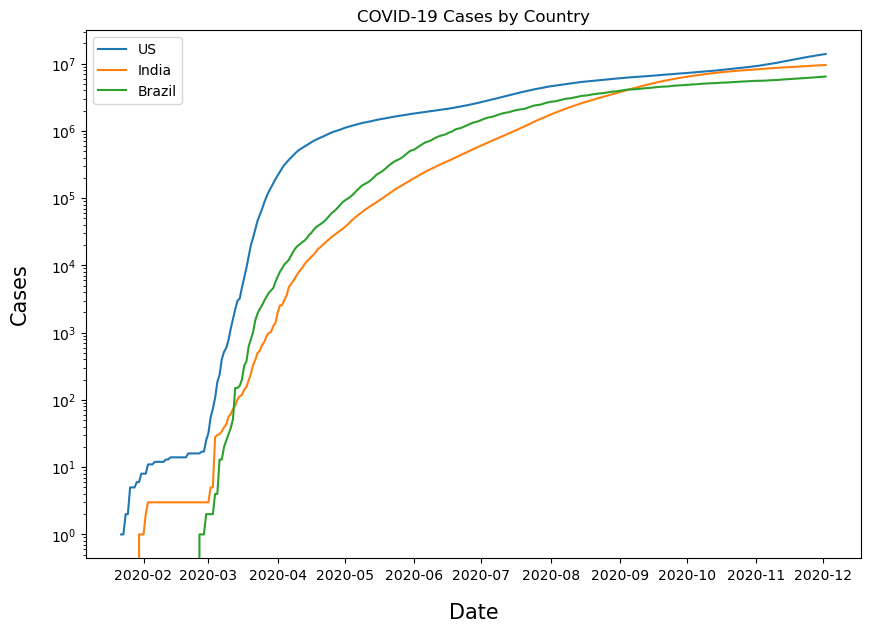

In [25]:
# Plot the data

#Initialize figure
fig1, ax1 = plt.subplots(figsize=(10, 7), dpi = fig_dpi)
selected_countries = ['US', 'India', 'Brazil']
# selected_countries = phase1_100cuts.columns
plotting_columns = covid_data[selected_countries]


# ax1.scatter(plotting_columns.index, plotting_columns, label = selected_countries)
# ax1.plot(plotting_columns, label=selected_countries)

# plt.plot(plotting_columns.index, plotting_columns[selected_countries], label=selected_countries)

ax1.plot(datetime_index, plotting_columns)



#Formatting

plt.title('COVID-19 Cases by Country')
ax1.legend(selected_countries) #set to show selected_countries
ax1.set_xlabel("Date", fontsize=axes_fontsize)
ax1.xaxis.labelpad = 15
ax1.yaxis.labelpad = 15
ax1.set_ylabel('Cases', fontsize=axes_fontsize)
ax1.set_yscale('log')

fig1.show()
fig1.savefig('../Figures/COVID-19_Cases_in_Select_Countries.png', bbox_inches="tight", pad_inches=0.3) 

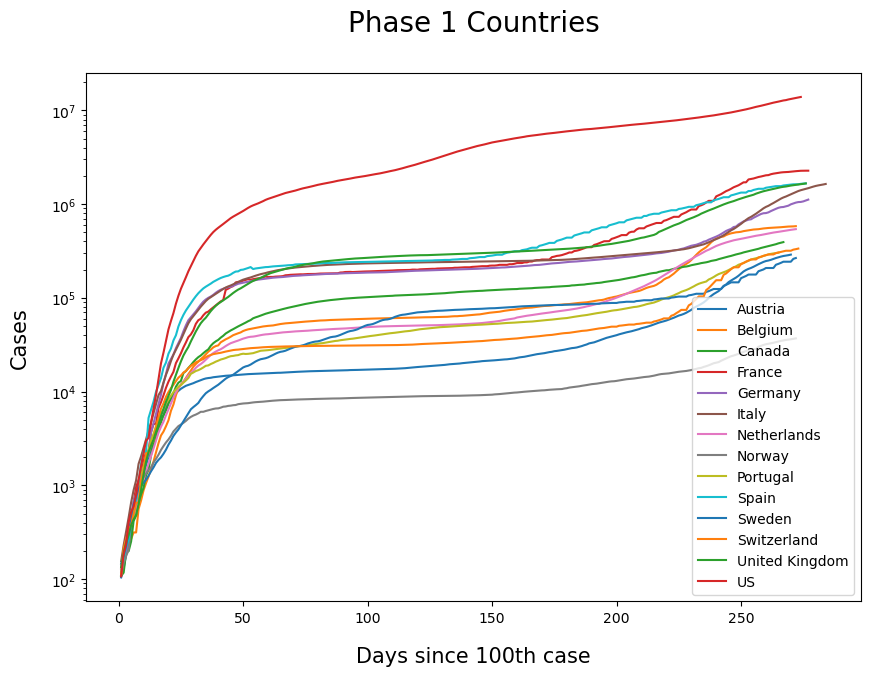

In [26]:
# Fig 2: Plotting Phase 1 Countries

#Initialize figure
fig2, ax1 = plt.subplots(figsize=(10, 7), dpi = fig_dpi)

#which countries should be plotted 
# selected_countries = ['US', 'India', 'Brazil'] #these ones
selected_countries = phase1_100cuts.columns # all of them
plotting_columns = countries_100cuts[selected_countries]


# ax1.scatter(plotting_columns.index, plotting_columns, label = selected_countries)
# ax1.plot(plotting_columns, label=selected_countries)

# plt.plot(plotting_columns.index, plotting_columns[selected_countries], label=selected_countries)

ax1.plot(countries_100cuts.index, plotting_columns)



#Formatting

plt.title('Phase 1 Countries', fontsize=title_fontsize, pad=30)
ax1.legend(selected_countries) #set to show selected_countries
ax1.set_xlabel("Days since 100th case", fontsize=axes_fontsize)
ax1.xaxis.labelpad = 15
ax1.yaxis.labelpad = 15
ax1.set_ylabel('Cases', fontsize=axes_fontsize)
ax1.set_yscale('log')

fig2.show()
fig2.savefig('../Figures/Phase_1_Countries.png', bbox_inches="tight", pad_inches=0.3)

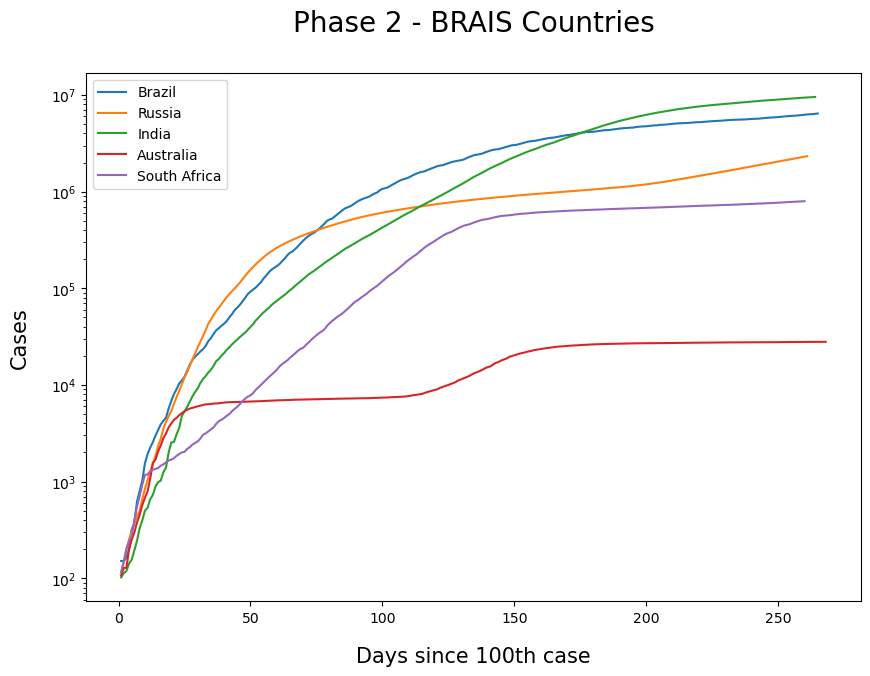

In [27]:
# Fig 3: Plotting BRIAS Nations

#Initialize figure
fig3, ax1 = plt.subplots(figsize=(10, 7), dpi = fig_dpi)

#which countries should be plotted 
selected_countries = ['Brazil', 'Russia', 'India', 'Australia', 'South Africa'] #these ones
plotting_columns = countries_100cuts[selected_countries]


# ax1.scatter(plotting_columns.index, plotting_columns, label = selected_countries)
# ax1.plot(plotting_columns, label=selected_countries)

# plt.plot(plotting_columns.index, plotting_columns[selected_countries], label=selected_countries)

ax1.plot(countries_100cuts.index, plotting_columns)



#Formatting

plt.title('Phase 2 - BRAIS Countries', fontsize=title_fontsize, pad=30)
ax1.legend(selected_countries) #set to show selected_countries
ax1.set_xlabel("Days since 100th case", fontsize=axes_fontsize)
ax1.xaxis.labelpad = 15
ax1.yaxis.labelpad = 15
ax1.set_ylabel('Cases', fontsize=axes_fontsize)
ax1.set_yscale('log')

fig3.show()
fig3.savefig('../Figures/Phase_2_BRIAS_Countries.png' , bbox_inches="tight", pad_inches=0.3)

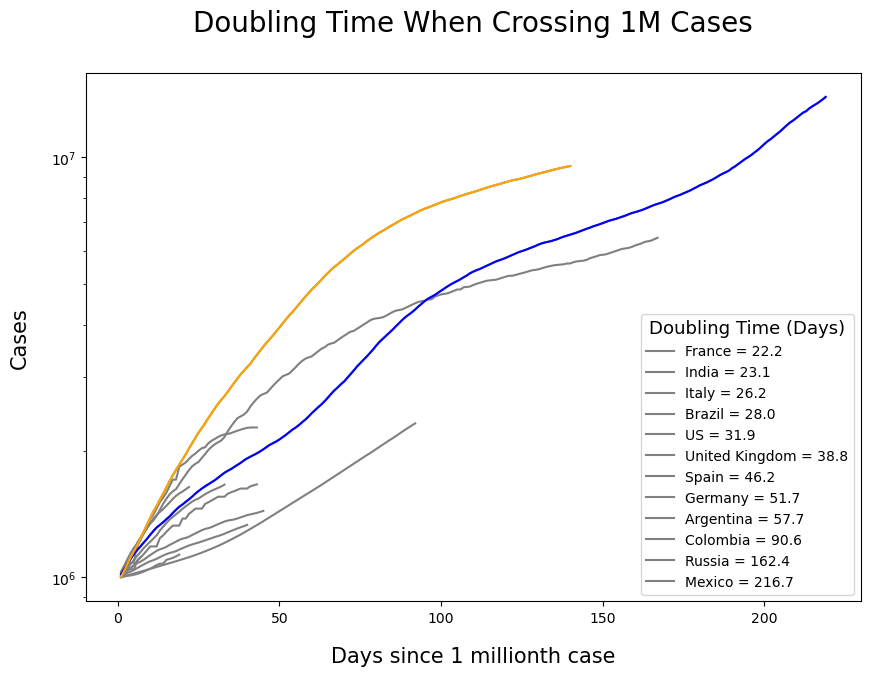

In [28]:
#Minimum number of cases for a country to be considered

seed_cutoff = 1000000


#Truncate the COVID-19 cases based on the variable seed_cutoff, defined above

countries_100cuts = covid_data.where(covid_data > seed_cutoff, np.nan)

for col in countries_100cuts.columns:
    countries_100cuts[col] = sorted(countries_100cuts[col], key=pd.isnull)


countries_100cuts.dropna(axis = 0, how = 'all', inplace = True)
countries_100cuts.insert(0, 'Days', range(1, 1 + len(countries_100cuts)))
countries_100cuts.set_index(['Days'], inplace=True)


#Calculate Doubling Times

doubling_window = 7 #days

doubling_time = (((doubling_window * np.log(2))) / (np.log(countries_100cuts.loc[7, :]) - np.log(countries_100cuts.loc[1, :]))).round(1)

doubling_time

#Convert Pandas series to dataframe
doubling_time = pd.DataFrame(doubling_time)

#Add an index column
doubling_time.reset_index(level=0, inplace=True)

#Rename the columns
doubling_time.columns = ['Country', 'Days']

#Removing blank rows
doubling_time['Days'].replace('', np.nan, inplace=True)
doubling_time.dropna(subset=['Days'], inplace=True)

#Sort by ascending order of doubling time
doubling_time = doubling_time.sort_values(by='Days')

doubling_countries = doubling_time.Country.unique()
doubling_time['Days'] = doubling_time['Days'].astype(str)

# Fig 4: Plotting Doubling Countries 
#-----------------------------------


#Initialize figure
fig4, ax1 = plt.subplots(figsize=(10, 7), dpi = fig_dpi)

#which countries should be plotted 

selected_countries = doubling_countries
plotting_columns = countries_100cuts[selected_countries]



#Doubling Time 
legend_doubling_time = doubling_time['Country'] + str(" = ") + doubling_time['Days']
# doubling_time_string = doubling_time.to_string
# legend_doubling_time = doubling_time_string.Country.str.cat(doubling_time_string.Days,sep=" ")
# legend_doubling_time

#Formatting

ax1.plot(countries_100cuts.index, plotting_columns, color='grey')
ax1.plot(countries_100cuts.index, plotting_columns['US'], color='blue')
ax1.plot(countries_100cuts.index, plotting_columns['India'], color='orange')

plt.title('Doubling Time When Crossing 1M Cases', fontsize=title_fontsize, pad=30)
ax1.legend(legend_doubling_time, title='Doubling Time (Days)', title_fontsize = 13)
ax1.set_xlabel("Days since 1 millionth case", fontsize=axes_fontsize)
ax1.xaxis.labelpad = 15
ax1.yaxis.labelpad = 15
ax1.set_ylabel('Cases', fontsize=axes_fontsize)
ax1.set_yscale('log')

fig4.show()
fig4.savefig('../Figures/Doubling_time_when_crossing_1M_cases.png', bbox_inches="tight", pad_inches=0.3)

In [29]:
doubling_time

,Country,Days
62,France,22.2
79,India,23.1
85,Italy,26.2
23,Brazil,28.0
176,US,31.9
180,United Kingdom,38.8
160,Spain,46.2
66,Germany,51.7
6,Argentina,57.7
37,Colombia,90.6
